In [1]:
import mplfinance as mpf
import pymssql
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import recall_score,precision_score

db_settings = {
    "host": "127.0.0.1",
    "user": "mssql",
    "password": "1234@@abcdABCD",
    "database": "stock",
    "charset": "utf8"
}
stock50 = ['2330', '2317', '2454', '2303', '2308', '2891', '2881', '2882', '1301', '1303', '2412', '2002', '2886', '2884', '2603', '3711', '5871', '1216', '2885', '2883', '2892', '5880', '1326', '3037', '1101', '2357', '2880', '3034', '2382', '2887', '2609', '2379', '2615', '2327', '2207', '3045', '2409', '3008', '6415', '5876', '2395', '2912', '1590', '6505', '2801', '4904', '8046', '9910', '2408', '8454']

In [5]:
def get_data(company):
    try:  
        conn = pymssql.connect(**db_settings)
        with conn.cursor() as cursor:
            command = f"SELECT date, o, c, h, l, tv, v, MA5, MA10 FROM [dbo].[stock_data] WHERE company = '{company}' ORDER BY date"
            cursor.execute(command)
            result = cursor.fetchall()
    except Exception as ex:
        print(ex)
    arr = []
    for r in result:
        r = list(r)
        r[0] = r[0].strftime("%Y-%m-%d")
        r[1] = float(r[1])
        r[2] = float(r[2])
        r[3] = float(r[3])
        r[4] = float(r[4])
        arr.append(r)
    return arr[10:len(arr)]

In [49]:
def plot_candle(data):
    df = pd.DataFrame([sublist[0:3]+[np.max(sublist[1:3])]+[np.min(sublist[1:3])] for sublist in data])
    df.index = pd.to_datetime(df[0])
    df = df.drop(columns=[0])
    df.columns = ['Open', 'Close', 'High', 'Low']
    df.index.name = "Date"
    mc = mpf.make_marketcolors(up='r',down='g')
    s  = mpf.make_mpf_style(marketcolors=mc)
    mpf.plot(df, type='candle', style=s, figsize=(20,2), ylim=(540,660))

Ground Truth:


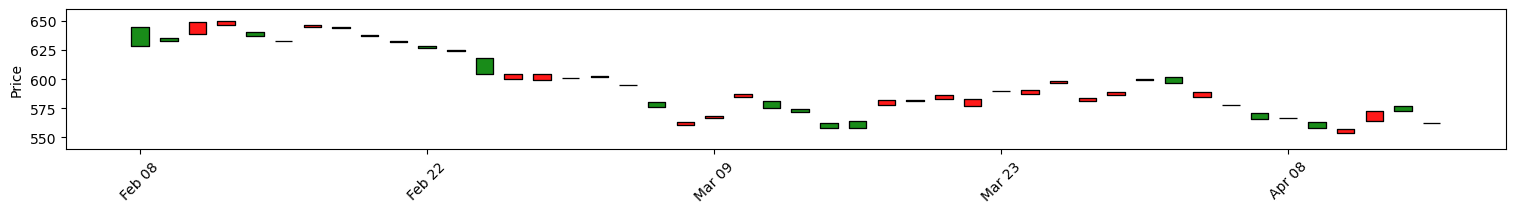

Predicted Candlestick Chart:


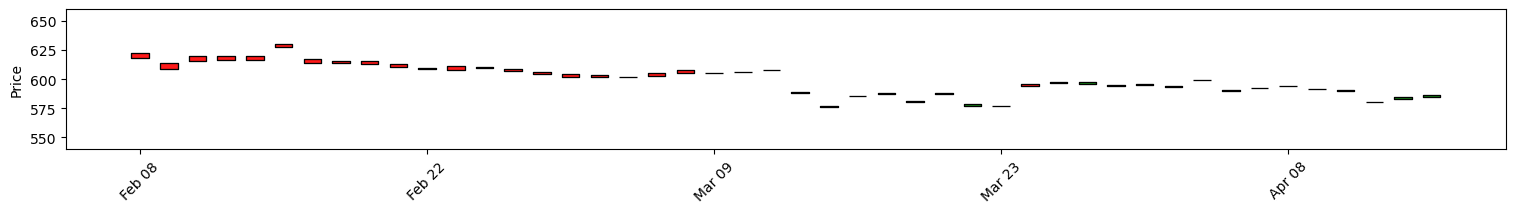

Coefficient of Determination: 0.4918874164531244


In [96]:
window = 10
predict = 4 # 0: predict tomorrow
bias = window + predict
trainX = []
trainY = []
for company in stock50:
    if company != '2330':
        data = get_data(company)
        data = [sublist[1:len(sublist)] for sublist in data]
        for day in range(len(data)-bias):
            trainX.append([element for sublist in data[day:day+window] for element in sublist])
            trainY.append(data[day+bias][0:2])

data = get_data('2330')
partition = int(len(data)*0.8)
trainD = data[0:partition]
testD = data[partition:len(data)]
trainD = [sublist[1:len(sublist)] for sublist in trainD]
for day in range(len(trainD)-bias):
    trainX.append([element for sublist in trainD[day:day+window] for element in sublist])
    trainY.append(trainD[day+bias][0:2])
testX = []
testY = []
timeline = [sublist[0] for sublist in testD]
testD = [sublist[1:len(sublist)] for sublist in testD]
for day in range(len(testD)-bias):
    testX.append([element for sublist in testD[day:day+window] for element in sublist])
    testY.append(testD[day+bias][0:2])

model = ExtraTreesRegressor(random_state=0,n_estimators=100)
for day in range(len(timeline)-bias):
    testY[day].insert(0,timeline[day+bias])
print('Ground Truth:')
plot_candle(testY)
testY = [sublist[1:len(sublist)] for sublist in testY]
model.fit(trainX,trainY)
predictY = model.predict(testX)
predictY = predictY.tolist()
for day in range(len(timeline)-bias):
    predictY[day].insert(0,timeline[day+bias])
print('Predicted Candlestick Chart:')
plot_candle(predictY)
print('Coefficient of Determination: '+str(model.score(testX, testY)))

In [18]:
def train_model(window,predict,partition):
    bias = window + predict
    trainX = []
    trainY = []
    for company in stock50:
        if company != '2330':
            data = get_data(company)
            data = [sublist[1:len(sublist)] for sublist in data]
            for day in range(len(data)-bias):
                trainX.append([element for sublist in data[day:day+window] for element in sublist])
                trainY.append(data[day+bias][0:2])

    data = get_data('2330')
    trainD = data[0:partition]
    trainD = [sublist[1:len(sublist)] for sublist in trainD]
    for day in range(len(trainD)-bias):
        trainX.append([element for sublist in trainD[day:day+window] for element in sublist])
        trainY.append(trainD[day+bias][0:2])

    model = ExtraTreesRegressor(random_state=0,n_estimators=100)
    model.fit(trainX,trainY)
    return model

Ground Truth:


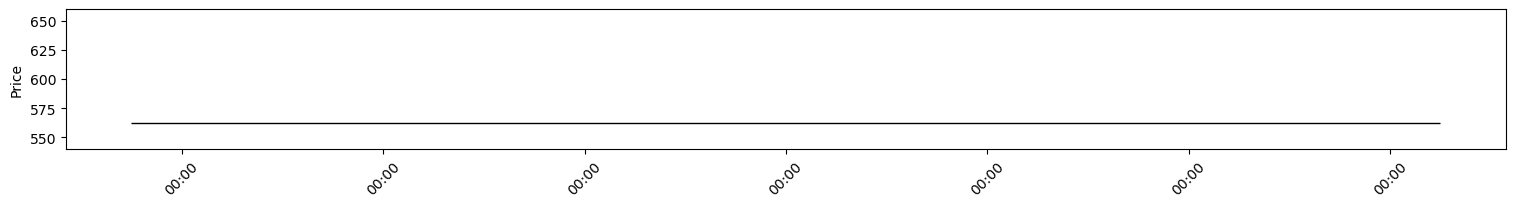

Predicted Candlestick Chart:


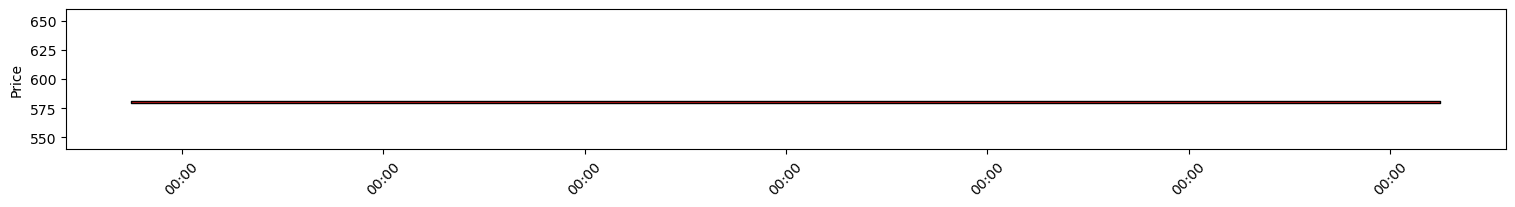

In [58]:
window = 10
predict = 10
bias = window + predict

models = []
for i in range(predict):
    models.append(train_model(window,i,partition))

data = get_data('2330')
partition = int(len(data)*0.8)
testD = data[partition:len(data)]
testX = []
testY = []
timeline = [sublist[0] for sublist in testD]
timeline = timeline[window:len(timeline)]
testD = [sublist[1:len(sublist)] for sublist in testD]
for day in range(len(timeline)):
    testX.append([element for sublist in testD[day:day+window] for element in sublist])
    testY.append([timeline[day]]+testD[day+window][0:2])

for day in range(len(timeline)):
    predicts = []
    for i in range(min(len(models),len(testY)-day)):
        predicts.append(models[i].predict([testX[day]]))
        predicts[i] = predicts[i].tolist()
        predicts[i] = predicts[i][0]
        predicts[i].insert(0,timeline[day+i])
    clear_output(wait=True)
    print('Ground Truth:')
    plot_candle(testY[day:min(day+predict,len(testY))])
    print('Predicted Candlestick Chart:')
    plot_candle(predicts)
    time.sleep(2)

Ground Truth:


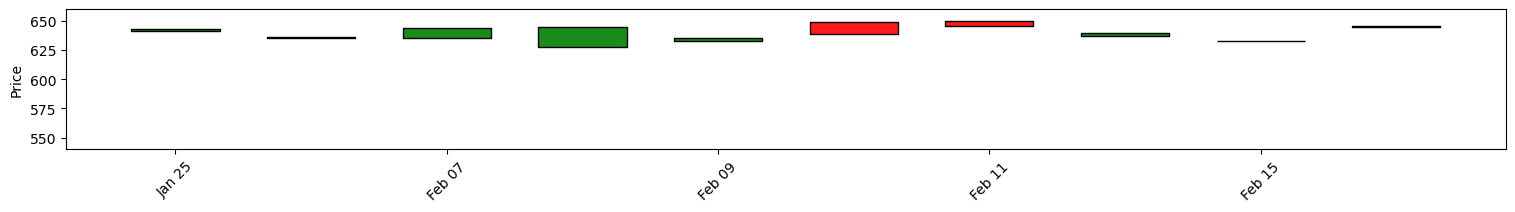

Predicted Candlestick Chart:


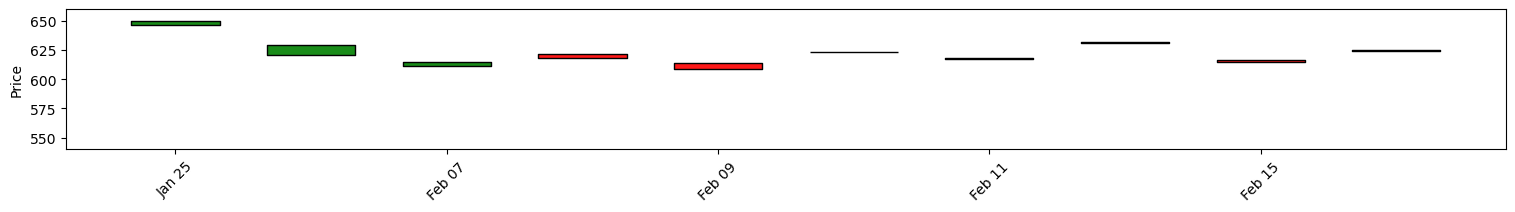

KeyboardInterrupt: 

In [95]:
window = 10
predict = 10
bias = window + predict

data = get_data('2330')
partition = int(len(data)*0.8)
testD = data[partition:len(data)]
testX = []
testY = []
timeline = [sublist[0] for sublist in testD]
timeline = timeline[window:len(timeline)]
testD = [sublist[1:len(sublist)] for sublist in testD]
for day in range(len(timeline)):
    testX.append([element for sublist in testD[day:day+window] for element in sublist])
    testY.append([timeline[day]]+testD[day+window][0:2])

for day in range(len(timeline)):
    predicts = []
    for i in range(min(len(models),len(testY)-day)):
        predicts.append(models[i].predict([testX[day]]))
        predicts[i] = predicts[i].tolist()
        predicts[i] = predicts[i][0]
        predicts[i].insert(0,timeline[day+i])
    clear_output(wait=True)
    print('Ground Truth:')
    plot_candle(testY[day:min(day+predict,len(testY))])
    print('Predicted Candlestick Chart:')
    plot_candle(predicts)
    time.sleep(2)